# Exercise sheet 2

Implement gradient descent with backtracking line search. Run it on some example problems. In the two-dimensional case, plot some contour plots.

**Please turn in your exercises by November 4th.**

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [16]:
def contour_map(f, xb=(-1,1), yb=(-1,1)):
    (nx, ny) = (45, 45)
    x = np.linspace(*xb, nx)
    y = np.linspace(*yb, ny)
    xv, yv = np.meshgrid(x, y)
    X = np.block([ [xv.reshape(1, -1)], [yv.reshape(1, -1)] ]).T
    zv = np.fromiter((f(x) for x in X), dtype=np.double)
    zv = zv.reshape(nx,ny)
    plt.contour(xv, yv, zv, 15)

def surface_plot(f, xb=(-1,1), yb=(-1,1)):
    (nx, ny) = (45, 45)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = np.linspace(*xb, nx)
    y = np.linspace(*yb, ny)
    xv, yv = np.meshgrid(x, y)
    X = np.block([ [xv.reshape(1, -1)], [yv.reshape(1, -1)] ]).T
    zv = np.fromiter((f(x) for x in X), dtype=np.double)
    zv = zv.reshape(nx,ny)
    ax.plot_surface(xv, yv, zv, cmap=cm.coolwarm)
    return fig, ax

## Task 1: Backtracking line search

Implement backtracking line search from the lecture. Use the function definition given below.
* `x` is the starting point of the line search.
* `d` is the direction of the line search ($\Delta x$).
* `f` is the function you are trying to minimize.
* `g` is the gradient of `f`
* `alpha` and `beta` are hyperparameters
  
The `backtracking_line_search` should return one scalar > 0.

In [29]:
import numpy as np

def backtracking_line_search(x, d, f, grad_f, alpha=0.3, beta=0.8):
    """
    Performs backtracking line search to find a suitable step size.

    Parameters:
    - x: Current point.
    - d: Descent direction (typically -grad_f(x)).
    - f: Function to minimize.
    - grad_f: Gradient of the function.
    - alpha: Armijo condition parameter.
    - beta: Step size reduction factor.

    Returns:
    - t: Step size that satisfies the Armijo condition.
    """
    t = 1.0
    while f(x + t * d) > f(x) + alpha * t * np.dot(grad_f(x), d):
        t *= beta
    return t

Your line search implementation should pass all of the below asserts.

In [30]:
x0 = 0.5 * np.ones(2)

A = np.array([[30, 15],[-20, 25]])
f = lambda x: x.T@A@x
g = lambda x: (A+A.T)@x
d = -g(x0)

assert abs(  backtracking_line_search(x0, d, f, g) - 0.02251799    ) < 1e-3


f = lambda x: np.linalg.norm(np.sin(x))**2
g = lambda x: 2 * np.sin(x) * np.cos(x)
d = -g(x0)

assert abs(  backtracking_line_search(x0, d, f, g) - 0.8                         ) < 1e-3
assert abs(  backtracking_line_search(x0, d, f, g, alpha=0.4) - 0.64             ) < 1e-3
assert abs(  backtracking_line_search(x0, d, f, g, alpha=0.4, beta=0.9)  - 0.729 ) < 1e-3



x0 = np.ones(3)
f = lambda x: x[0]**2 - 3 * x[0] * x[1] + x[1]**2 + x[2]**2
g = lambda x: np.array([2*x[0] - 3*x[1], 2*x[1] - 3*x[0], 2 * x[2]])
d = -20 * g(x0)

assert abs(  backtracking_line_search(x0, d, f, g) - 0.06872        ) < 1e-3

## Task 2: Gradient descent
Implement gradient descent using the backtracking line search.
* `x0` is the initial point.
* `f` is the function you are trying to minimize.
* `g` is the gradient of `f`.

Function `gradient_descent` should return the minimum.

In [31]:
def gradient_descent(x0, f, grad_f, max_iter=1000, tol=1e-5):
    """
    Performs gradient descent using backtracking line search to find the minimum of a function.

    Parameters:
    - x0: Initial point.
    - f: Function to minimize.
    - grad_f: Gradient of the function.
    - max_iter: Maximum number of iterations.
    - tol: Tolerance for the stopping criterion based on the gradient norm.

    Returns:
    - x: Point that approximately minimizes the function.
    """
    x = x0
    for _ in range(max_iter):
        grad = grad_f(x)
        if np.linalg.norm(grad) < tol:
            break
        d = -grad
        t = backtracking_line_search(x, d, f, grad_f)
        x = x + t * d
    return x

Your line search implementation should pass all of the below asserts.

In [10]:
x0 = 0.5 * np.ones(2)

A = np.array([[30, 15],[-20, 25]])
f = lambda x: x.T@A@x + 1
g = lambda x: (A+A.T)@x

assert abs(f( gradient_descent(x0, f, g, max_iter=1000) )-1.) < 1e-3



f = lambda x: np.linalg.norm(np.sin(x))**2
g = lambda x: 2 * np.sin(x) * np.cos(x)

assert abs(f(  gradient_descent(x0, f, g) )) < 1e-3
assert abs(f(  gradient_descent(x0 + 3., f, g) )) < 1e-3



x0 = np.ones(3)
f = lambda x: x[0]**2 - 2 * x[0] * x[1] + x[1]**2 + x[2]**2
g = lambda x: np.array([2*x[0] - 2*x[1], 2*x[1] - 2*x[0], 2 * x[2]])

assert abs(f(  gradient_descent(x0, f, g) )) < 1e-3

## Task 3: Surface plot, contour map, and path

Implement `gradient_descent_path` that returns the minimum and all the `x`s in between and plot them.

In [13]:
import numpy as np

def gradient_descent_path(x0, f, grad_f, max_iter=100, tol=1e-5):
    """
    Performs gradient descent with backtracking line search and records each step in the descent path.

    Parameters:
    - x0: Initial point.
    - f: Function to minimize.
    - grad_f: Gradient of the function.
    - max_iter: Maximum number of iterations.
    - tol: Tolerance for stopping criterion based on gradient norm.

    Returns:
    - xs: List of points in the path taken by gradient descent.
    """
    x = x0
    path = [x]

    for _ in range(max_iter):
        grad = grad_f(x)
        if np.linalg.norm(grad) < tol:
            break
        d = -grad
        t = backtracking_line_search(x, d, f, grad_f)
        x = x + t * d
        path.append(x)

    return np.array(path)

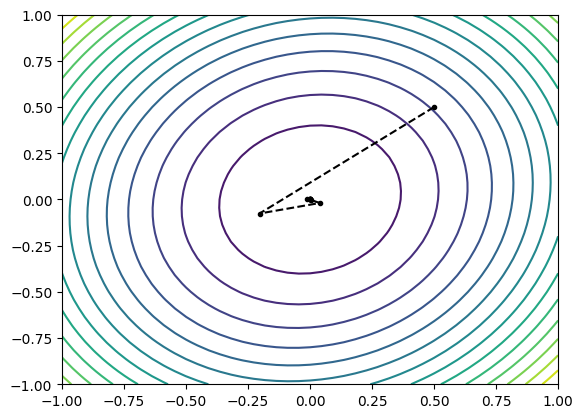

In [17]:
x0 = 0.5 * np.ones(2)

A = np.array([[30., 15],[-20, 25]])/20

f = lambda x: x.T@A@x + 1
g = lambda x: (A+A.T)@x

xs = gradient_descent_path(x0, f, g)
xs = np.array(xs)
contour_map(f)
plt.plot(xs[:,0], xs[:,1], '.--k')
plt.show()


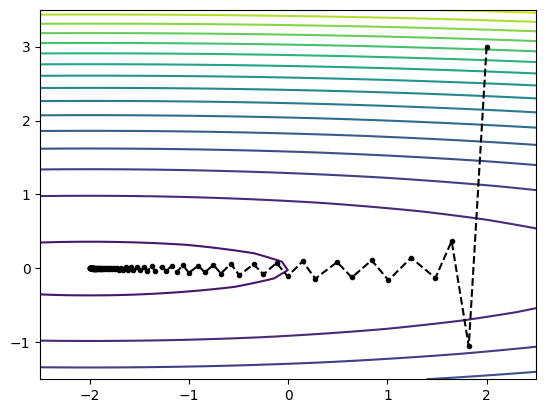

In [18]:
x0 = np.array([2.,3.])

f = lambda x: (x[0]**2 + 30 * x[1]**2 + 4 * x[0])
g = lambda x: np.array([2 * x[0] + 4, 60 * x[1]])

xs = gradient_descent_path(x0, f, g)
xs = np.array(xs)
contour_map(f, xb=(-2.5,2.5), yb=(-1.5,3.5))
plt.plot(xs[:,0], xs[:,1], '.--k')
plt.show()

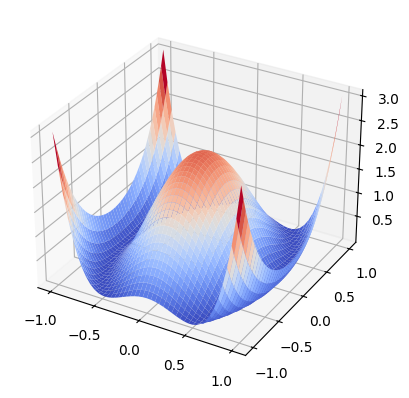

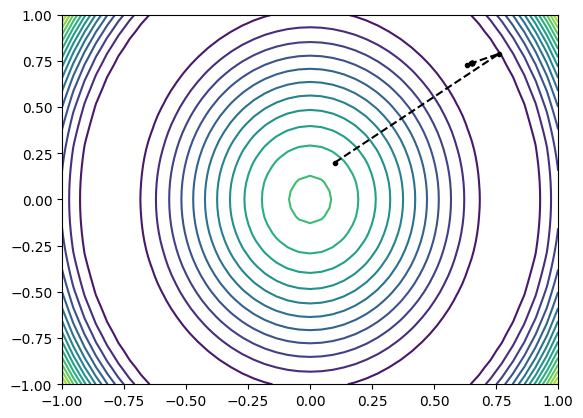

In [19]:
x0 = np.array([.1, .2])
b = np.array([1.5,1.])
f = lambda x: (np.linalg.norm(x * b)**2 - 1.5)**2
g = lambda x: 4 * (np.linalg.norm(x*b)**2 - 1.5) * x * b*b

surface_plot(f)
plt.show()

xs = gradient_descent_path(x0, f, g)
xs = np.array(xs)
contour_map(f)
plt.plot(xs[:,0], xs[:,1], '.--k')
plt.show()

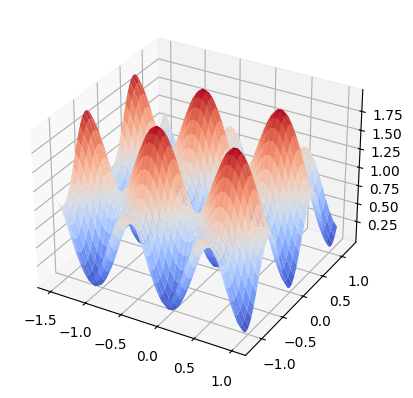

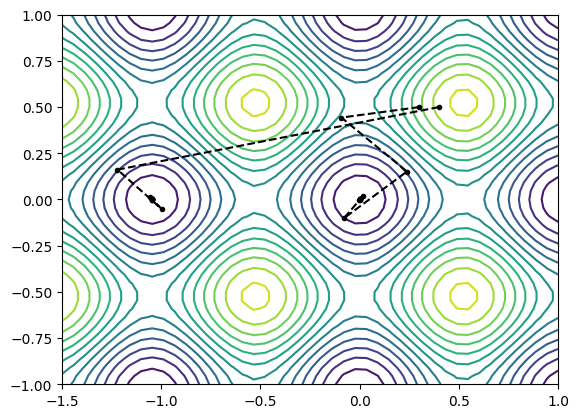

In [20]:
x0 = np.array([.3,.5])

f = lambda x: np.linalg.norm(np.sin(x*3))**2
g = lambda x: 6 * np.sin(x*3) * np.cos(x*3)

surface_plot(f, xb=(-1.5, 1.), yb=(-1.2,1.2))
plt.show()

xs = gradient_descent_path(x0, f, g)
xs = np.array(xs)
contour_map(f, xb=(-1.5, 1.), yb=(-1.,1.))
plt.plot(xs[:,0], xs[:,1], '.--k')

x0 = np.array([.4,.5])
xs = gradient_descent_path(x0, f, g)
xs = np.array(xs)
plt.plot(xs[:,0], xs[:,1], '.--k')
plt.show()


## Task 4: Linear regression


### 2D linear regression

Finish the gradient `g` of the linear regression loss.

Additionaly to the contour map, plot the gradient and loss function over iterations.

In [21]:
from sklearn.datasets import make_regression

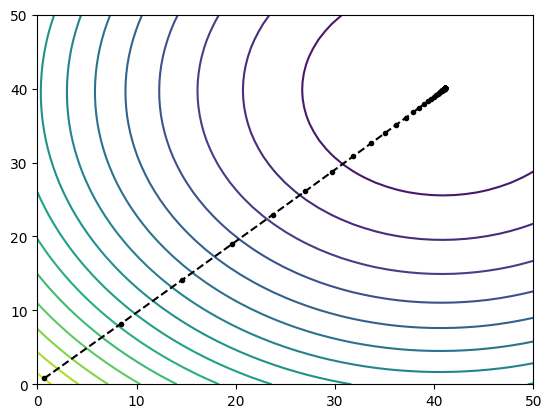

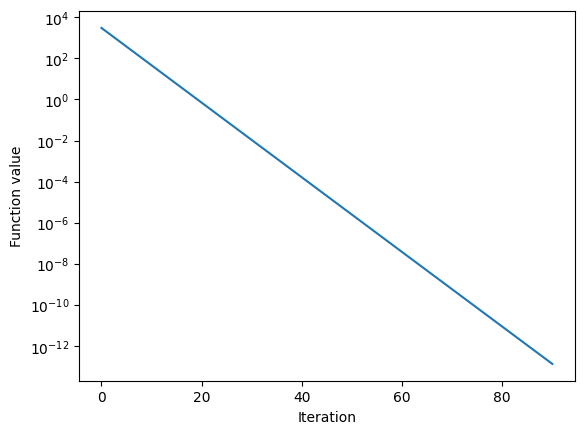

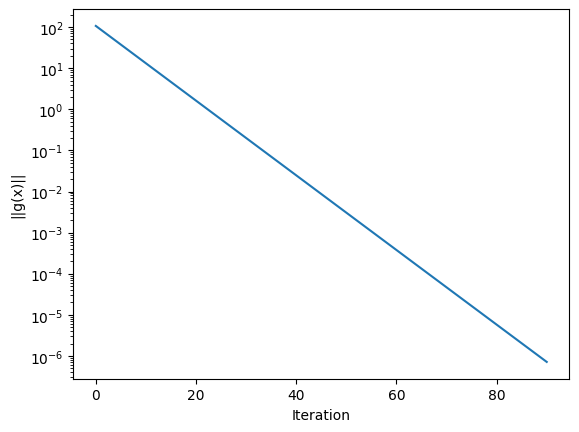

In [22]:
X, y = make_regression(n_samples=1000, n_features=2, n_informative=2, random_state=0)

def f(w):
    return np.linalg.norm(X @ w - y) ** 2 / len(X)

def g(w):
    return (2 / len(X)) * X.T @ (X @ w - y)

# Gradient descent function to get the path of weights
def gradient_descent_path(w0, f, g, learning_rate=0.1, tol=1e-6, max_iter=1000):
    w = w0
    path = [w]
    for i in range(max_iter):
        grad = g(w)
        w = w - learning_rate * grad
        path.append(w)
        if np.linalg.norm(grad) < tol:
            break
    return path

x0 = np.array([.7, .8])
xs = gradient_descent_path(x0, f, g)
xs = np.array(xs)

contour_map(f,xb=(0,50), yb=(0,50))
plt.plot(xs[:,0], xs[:,1], '.--k')
plt.show()

plt.semilogy(np.arange(len(xs)), [f(x) for x in xs])
plt.xlabel('Iteration')
plt.ylabel('Function value')
plt.show()

plt.semilogy(np.arange(len(xs)), [np.linalg.norm(g(x)) for x in xs])
plt.xlabel('Iteration')
plt.ylabel('||g(x)||')
plt.show()

### High-dimensional linear regression

Plot the function value and norm of gradient for this high-dimensional dataset.

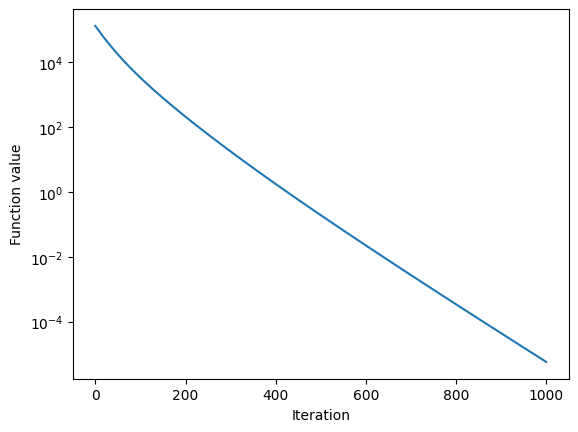

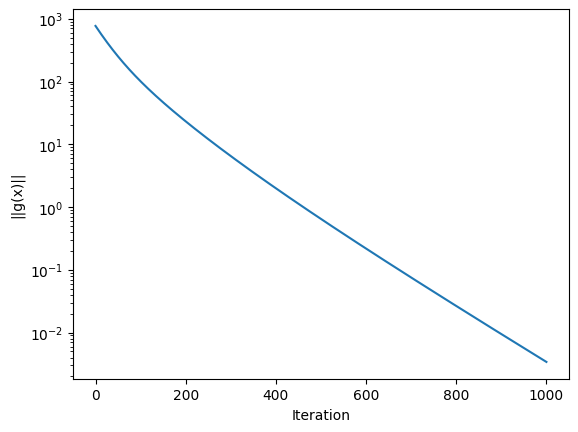

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression

X, y = make_regression(n_samples=1000, n_features=100, n_informative=40, random_state=0)

def f(w):
    return np.linalg.norm(X @ w - y) ** 2 / len(X)

def g(w):
    return (2 / len(X)) * X.T @ (X @ w - y)

def gradient_descent_path(w0, f, g, learning_rate=0.01, tol=1e-6, max_iter=1000):
    w = w0
    path = [w]
    for i in range(max_iter):
        grad = g(w)
        w = w - learning_rate * grad
        path.append(w)
        if np.linalg.norm(grad) < tol:
            break
    return path

x0 = np.zeros(100)
xs = gradient_descent_path(x0, f, g)
xs = np.array(xs)

plt.semilogy(np.arange(len(xs)), [f(x) for x in xs])
plt.xlabel("Iteration")
plt.ylabel("Function value")
plt.show()

plt.semilogy(np.arange(len(xs)), [np.linalg.norm(g(x)) for x in xs])
plt.xlabel("Iteration")
plt.ylabel("||g(x)||")
plt.show()


## Task 5: Logistic regression



### 2D logistic regression

Finish the gradient `g` of the logistic regression loss.

Additionaly to the given contour map, plot the gradient and loss function over iterations.

In [ ]:
from sklearn.datasets import make_classification

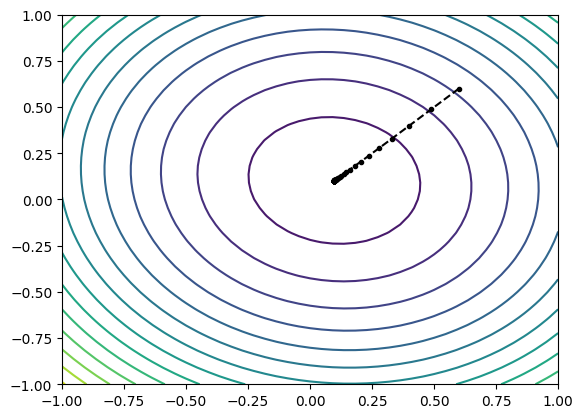

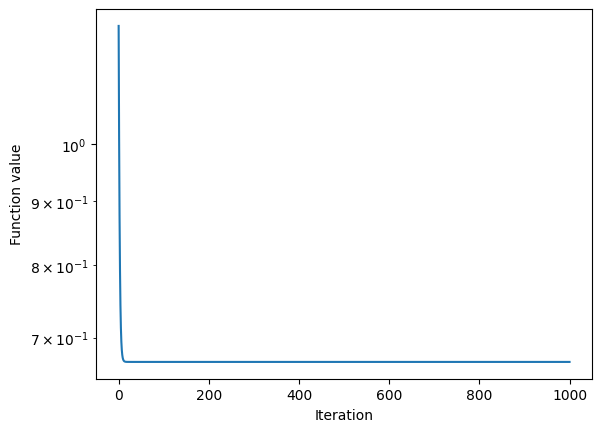

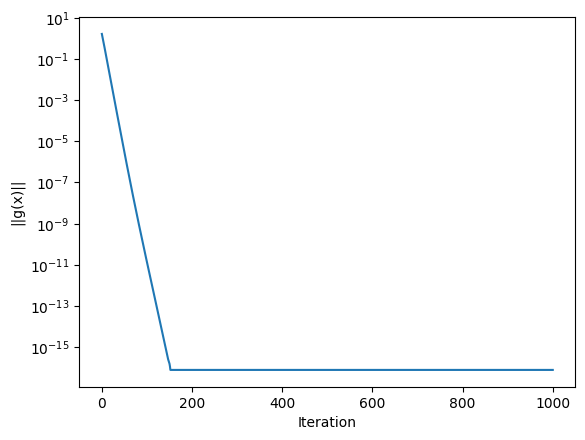

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

X, y = make_classification(1000, 2, n_informative=2, n_redundant=0, n_clusters_per_class=1, flip_y=0.1, random_state=0)

def f(w):
    return np.log(1. + np.exp(-y * X.dot(w))).mean() + np.linalg.norm(w)**2

def g(w):
    grad_logistic = -(X.T.dot(y * (1. / (1. + np.exp(y * X.dot(w)))))) / len(y)

    grad_reg = 2 * w
    return grad_logistic + grad_reg

def gradient_descent_path(x0, f, g, learning_rate=0.1, max_iter=1000):
    x = x0
    path = [x]
    for _ in range(max_iter):
        x = x - learning_rate * g(x)
        path.append(x)
    return path


x0 = np.array([.6, .6])
xs = gradient_descent_path(x0, f, g)
xs = np.array(xs)

contour_map(f)
plt.plot(xs[:,0], xs[:,1], '.--k')
plt.show()

plt.semilogy(np.arange(len(xs)), [f(x) for x in xs])
plt.xlabel('Iteration')
plt.ylabel('Function value')
plt.show()

plt.semilogy(np.arange(len(xs)), [np.linalg.norm(g(x)) for x in xs])
plt.xlabel('Iteration')
plt.ylabel('||g(x)||')
plt.show()

### High-dimensional logistic regression

Plot the function value and norm of gradient for this high-dimensional dataset.


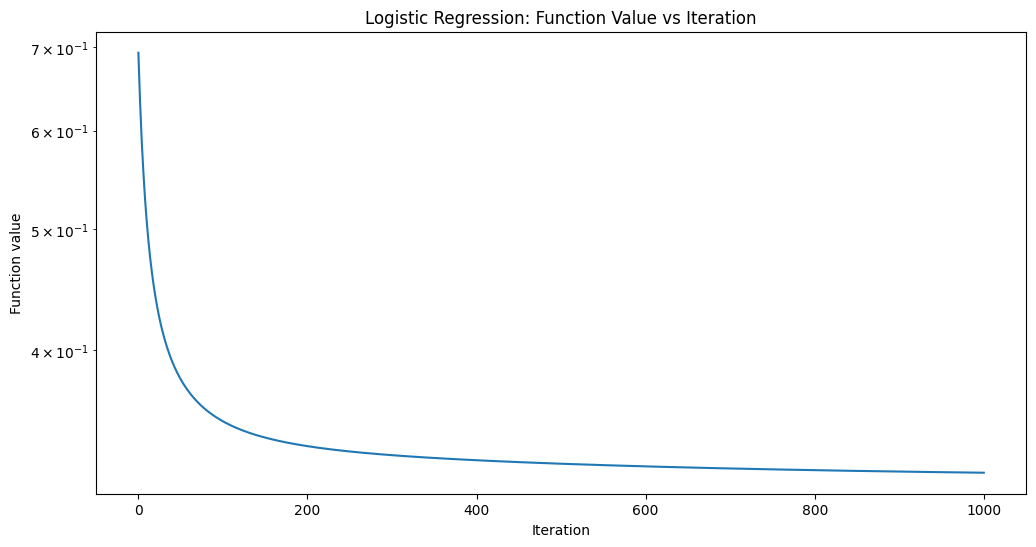

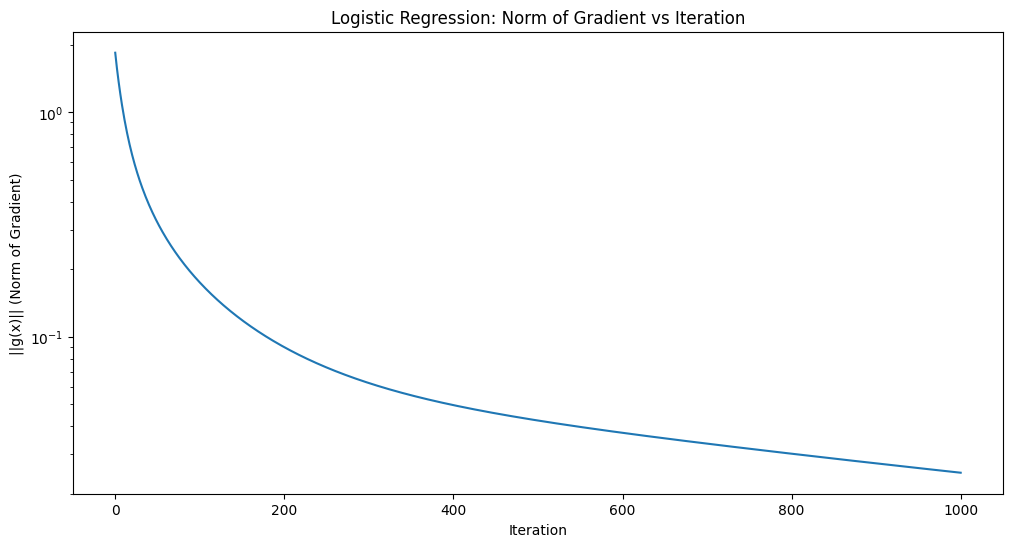

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

X, y = make_classification(1000, 80, n_informative=40, n_clusters_per_class=2, flip_y=0.1, random_state=0)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def f(x):
    z = X @ x
    predictions = sigmoid(z)
    return -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))

def g(x):
    z = X @ x
    predictions = sigmoid(z)
    return X.T @ (predictions - y) / X.shape[0]

def gradient_descent_path(x0, f, g, alpha=0.01, max_iter=1000, tol=1e-6):
    xs = [x0]
    x = x0
    for i in range(max_iter):
        grad = g(x)
        x = x - alpha * grad
        xs.append(x)
        if np.linalg.norm(grad) < tol:
            break
    return xs


x0 = np.zeros(80)

xs = gradient_descent_path(x0, f, g)

plt.figure(figsize=(12, 6))
plt.semilogy(np.arange(len(xs)), [f(x) for x in xs])
plt.xlabel('Iteration')
plt.ylabel('Function value')
plt.title('Logistic Regression: Function Value vs Iteration')
plt.show()

plt.figure(figsize=(12, 6))
plt.semilogy(np.arange(len(xs)), [np.linalg.norm(g(x)) for x in xs])
plt.xlabel('Iteration')
plt.ylabel('||g(x)|| (Norm of Gradient)')
plt.title('Logistic Regression: Norm of Gradient vs Iteration')
plt.show()

# Task 6: Negative gradient direction

Show that the negative gradient is in some sense the best direction, i.e., it minimizes the following optimization problem:
$$
\begin{array}{ll}
\displaystyle\min_{v\in\mathbb{R}^d} & \nabla f(x)^\top v\\
\text{st}& \|v\|_2 = 1
\end{array}
$$
Write your proof here.




The **gradient**

$$
\nabla f(x)
$$ at

$$
x
$$

points in the direction of the **steepest ascent** of the function

$$
f(x)
$$.

Therefore, the **negative gradient**

$$
-\nabla f(x)
$$

points in the direction of the **steepest descent**.

We aim to show that

$$
v = -\frac{\nabla f(x)}{\|\nabla f(x)\|_2}
$$

minimizes

$$
\nabla f(x)^\top v
$$

under the constraint

$$
\|v\|_2 = 1.
$$


Using the **Cauchy-Schwarz inequality**, we know that for any vectors

$$
a
$$

and

$$
b
$$

in

$$
\mathbb{R}^d
$$:

$$
|a^\top b| \leq \|a\|_2 \|b\|_2
$$

Equality holds if and only if

$$
a
$$

and

$$
b
$$

are collinear (i.e., one is a scalar multiple of the other).

In our case, let

$$
a = \nabla f(x)
$$

and

$$
b = v
$$,

with

$$
\|v\|_2 = 1.
$$

Then:

$$
|\nabla f(x)^\top v| \leq \|\nabla f(x)\|_2 \|v\|_2 = \|\nabla f(x)\|_2
$$


To minimize

$$
\nabla f(x)^\top v
$$,

we need to take

$$
v
$$

in the opposite direction of

$$
\nabla f(x)
$$,

because that will make

$$
\nabla f(x)^\top v
$$

as negative as possible, achieving the minimum value

$$
-\|\nabla f(x)\|_2
$$.

Thus, the minimizing direction is:

$$
v = -\frac{\nabla f(x)}{\|\nabla f(x)\|_2}
$$


Substituting this choice of

$$
v
$$

into the objective function:

$$
\nabla f(x)^\top v = \nabla f(x)^\top \left(-\frac{\nabla f(x)}{\|\nabla f(x)\|_2}\right) = -\|\nabla f(x)\|_2
$$

This is the minimum value of

$$
\nabla f(x)^\top v
$$

under the constraint

$$
\|v\|_2 = 1
$$.


Therefore, we have shown that the direction of the **negative gradient**

$$
-\nabla f(x)
$$

is indeed the direction that minimizes

$$
\nabla f(x)^\top v
$$

subject to

$$
\|v\|_2 = 1
$$.